<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Training-AI-Agents" data-toc-modified-id="Training-AI-Agents-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Training AI Agents</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Creating-the-Player-Class" data-toc-modified-id="Creating-the-Player-Class-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Creating the Player Class</a></span><ul class="toc-item"><li><span><a href="#Reading-in-shot_distr.csv" data-toc-modified-id="Reading-in-shot_distr.csv-1.0.2.1"><span class="toc-item-num">1.0.2.1&nbsp;&nbsp;</span>Reading in shot_distr.csv</a></span></li></ul></li><li><span><a href="#Creating-a-custom-Environment" data-toc-modified-id="Creating-a-custom-Environment-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Creating a custom Environment</a></span></li><li><span><a href="#Random-Agent-Decisions" data-toc-modified-id="Random-Agent-Decisions-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>Random Agent Decisions</a></span><ul class="toc-item"><li><span><a href="#Analysis:" data-toc-modified-id="Analysis:-1.0.4.1"><span class="toc-item-num">1.0.4.1&nbsp;&nbsp;</span>Analysis:</a></span></li><li><span><a href="#Analysis:" data-toc-modified-id="Analysis:-1.0.4.2"><span class="toc-item-num">1.0.4.2&nbsp;&nbsp;</span>Analysis:</a></span></li></ul></li><li><span><a href="#Q-Learning" data-toc-modified-id="Q-Learning-1.0.5"><span class="toc-item-num">1.0.5&nbsp;&nbsp;</span>Q Learning</a></span><ul class="toc-item"><li><span><a href="#Analysis-of-Q-Learning" data-toc-modified-id="Analysis-of-Q-Learning-1.0.5.1"><span class="toc-item-num">1.0.5.1&nbsp;&nbsp;</span>Analysis of Q-Learning</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Training AI Agents

### Imports

I am using Stable Baselines, and Open AI's gym to create and test the environment. I am also brining in player.py, that will provide the probabilities of an action happening, which are determined from NBA player statistics from the current NBA season.

In [1]:
#Lots of help from Dustin Pierce at General Assembly
#https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html
#https://github.com/koulanurag/ma-gym/blob/master/ma_gym/envs/pong_duel/pong_duel.py
#https://github.com/hardmaru/slimevolleygym/blob/master/slimevolleygym/slimevolley.py
#https://medium.com/@m.alzantot/you-can-see-what-is-the-observation-space-by-print-env-observation-space-c4e59e64ac52

import copy
import logging
import pandas as pd

import gym
import numpy as np
from gym import spaces
from gym.utils import seeding

logger = logging.getLogger(__name__)

import random
import time
# import ball  --potential future add on


In [2]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

### Creating the Player Class

#### Reading in shot_distr.csv

I am sampling from the distributions created in the previous workbook to use as shooting percentages for the players on offense.

In [4]:
df = pd.read_csv('../data/shot_distr.csv')

In [5]:
df.head()

,PLAYER_NAME,3pa,3pb,fga,fgb
0,Kristaps Porzingis,6.0,8.0,8.0,13.0
1,Luka Doncic,2.0,9.0,13.0,18.0
2,RJ Barrett,5.0,3.0,13.0,7.0
3,Julius Randle,2.0,5.0,9.0,11.0


In [6]:
class Player():
    
    def __init__(self, player_name, _has_ball=False):

        self.player_name = player_name
        self._is_defended = False
        self._has_ball = True
        self._close_range = False
        self._midrange = False
        self._three_point_range = True

        self.shooting_close = np.random.beta(df['fga'][df['PLAYER_NAME'] == self.player_name], df['fgb'][df['PLAYER_NAME'] == self.player_name])
        self.shooing_midrange = np.random.beta(df['fga'][df['PLAYER_NAME'] == self.player_name], df['fgb'][df['PLAYER_NAME'] == self.player_name])
        self.shooting3pts = np.random.beta(df['3pa'][df['PLAYER_NAME'] == self.player_name], df['3pb'][df['PLAYER_NAME'] == self.player_name])      

A player on defense for this simplified game would not need attributes for shooting, because as soon as the defense gets the ball the round is over and the environment is reset. They will have attributes to determine the probability of a steal and block instead.

In [ ]:
class PlayerD():

    def __init__(self, player_name):
        
        self.player_name = player_name
        self._is_defended = False
        self._has_ball = False
        self._close_range = False
        self._midrange = False
        self._three_point_range = True

        self.steal = np.random.beta(1, 25)
        self.block = np.random.beta(1, 25)

### Creating a custom Environment

In [7]:
class BasketballEnv(gym.Env):
    """
    Custom Environment that follows gym interface.
    This is a simple env where multiple agents learn strategies to put the ball in the hoop.
    For this simple iteration, actions will be determined by probabilities rather than physics.
    """
    # In google colab, we cannot implement the GUI ('human' render mode)
    metadata = {'render.modes': ['human', 'rgb_array']}

    
    def __init__(self, step_cost=0, reward=0, max_rounds=1):
        #Grid size will be standard basketball halfcourt at 6"=1'-0" scale
        self._grid_shape = (100, 94)

        #Number of players
        self.n_agents = 4
        self.n_teams = 2
        self.n_agents_team_A = int(self.n_agents / 2)
        self.n_agents_team_B = int(self.n_agents / 2)
        self.reward = reward
        self._max_rounds = max_rounds
        self.action_space = spaces.MultiDiscrete([9, 2, 2])
        self.player_w_ball=[True, False]

        self._step_count = 0
        self._step_cost = step_cost
        self._total_episode_reward = [0 for _ in range(self.n_teams)]
        self.agent_pos = {_: None for _ in range(self.n_agents)}
#         self.x = [self.agent_pos[x][0] for x in range(0,4)]
#         self.y = [self.agent_pos[y][1] for y in range(0,4)]
#         self.t = 24

        self._agent_dones = None
        self._rounds = 0

        # Observing agent positions for 4 agents
        self._obs_low = np.array([0., 0., 0., 0., 0., 0., 0., 0.])
        self._obs_high = np.array([1., 1., 1., 1., 1., 1., 1., 1,])
        self.observation_space = spaces.Box(low=self._obs_low, high=self._obs_high,
                                        dtype=np.float32)

        self.viewer = None
        self.seed()
        
    def is_done(self):
        if self._rounds >= self._max_rounds:
            return True
        
    def get_action_meanings(self, agent_i=None):
        if agent_i is not None:
            assert agent_i <= self.n_agents
            return [ACTION_MEANING[i] for i in range(self.action_space[agent_i].n)]
        else:
            return [[ACTION_MEANING[i] for i in range(ac.n)] for ac in self.action_space]

    def __create_grid(self):
        _grid = [[PRE_IDS['empty'] for _ in range(self._grid_shape[1])] for row in range(self._grid_shape[0])]
        return _grid

    def __update_agent_view(self, agent_i):
        for row in range(self.agent_prev_pos[agent_i][0],
                         self.agent_prev_pos[agent_i][0]):
            self._full_obs[row][self.agent_prev_pos[agent_i][1]] = PRE_IDS['empty']

        for row in range(self.agent_pos[agent_i][0], self.agent_pos[agent_i][0]):
            self._full_obs[row][self.agent_pos[agent_i][1]] = PRE_IDS['agent'] + str(agent_i + 1) \
                                                              + '_' + str(row - self.agent_pos[agent_i][0])

#     def __draw_base_img(self):
#         self._base_img = draw.draw_grid(self._grid_shape[0], self._grid_shape[1],
#                                    cell_size=CELL_SIZE, fill='white', line_color='white')

    def __init_full_obs(self):
        self._full_obs = self.__create_grid()
        for agent_i in range(self.n_agents):
            self.__update_agent_view(agent_i)

        for agent_i in range(self.n_agents):
            self.__update_agent_view(agent_i)

#         self.__draw_base_img()

    #Countdown timer as 24 second shot clock for each round
    #https://www.geeksforgeeks.org/how-to-create-a-countdown-timer-using-python/
#     def countdown(self, t=24):     
#         while t: 
#             mins, secs = divmod(t, 60) 
#             timer = '{:02d}:{:02d}'.format(mins, secs)  
#             time.sleep(1) 
#             t -= 1
#             self.t = t
    
#     def __init_countdown(self, t):
#         return self.countdown(t)
        

    def get_agent_obs(self):
        _obs = []

        for agent_i in range(self.n_agents):
            pos = self.agent_pos[agent_i]
            _agent_i_obs_a = pos[0] / self._grid_shape[0]
            _agent_i_obs_b = pos[1] / self._grid_shape[1]
            
            _obs.append(_agent_i_obs_a)
            _obs.append(_agent_i_obs_b)

        return np.array(_obs)
    
    def get_state_num(self):
        for agent_i in range(self.n_agents):
            return self.agent_pos[agent_i][0]*self._grid_shape[0] + self.agent_pos[agent_i][1]

    def get_pos_from_state_num(self, state_num):
        return (state_num // self._grid_shape[0], state_num % self._grid_shape[0])
    
##############
#Define Reset#   
##############

    def reset(self):
        self._rounds = 0
#         self.__init_countdown(24)
        
        #Set starting positions for agents in Team A
        self.agent_pos[0] = [self._grid_shape[0]//2, self._grid_shape[1] - 2]
        self.agent_pos[1] = [self._grid_shape[0]//5, self._grid_shape[1] - 2]

        
        #Set starting positions for agents in Team B
        self.agent_pos[2] = [self._grid_shape[0]//2, self._grid_shape[1] - 8]
        self.agent_pos[3] = [self._grid_shape[0]//5, self._grid_shape[1] - 8]

        
        self.agent_prev_pos = {_: self.agent_pos[_] for _ in range(self.n_agents)}
        self._agent_dones = False
        self.__init_full_obs()
        self._step_count = 0
        self._total_episode_reward = [0 for _ in range(self.n_teams)]

        return self.get_agent_obs()

    
###############################
#Define Properties and Actions#   
###############################
    
            
    #This will determine success of an action
    def action_success(self, p_1):
        return np.random.choice([0, 1], p=[1 - p_1, p_1])

    #Determine if a player is close to the goal
    def close_range(self):
        for agent_i in range(n_agents):
            if np.sqrt((self.pos[agent_i][0] - GOAL[0])**2 + (self.pos[agent_i][1]-GOAL[1])**2) <= 6:
                player._close_range = True
                player._midrange = False
                player._three_point_range = False

    #Determine if a player is mid-range from the goal
    def midrange(self):
        for agent_i in range(n_agents):
            if player._close_range == False and player._three_point_range == False:
                player._midrange = True
                    

    #Determine if a player is in three point range
    def _three_point_range(self):
        for agent_i in range(n_agents):
            if self.pos[agent_i][1] <= 19.67 and self.pos[agent_i][0] <= 6.67 or self.pos[agent_i][1] >= 93.33:
                player._three_point_range = True
            elif self.pos[agent_i][1] > 19.67 and np.sqrt((self.pos[agent_i][0] - GOAL[0])**2 + (self.pos[agent_i][1]-GOAL[1])**2) > 44.3:
                player._three_point_range = True
                player._midrange = False
                player._close_range = False
        
    def rebound(self):
        if self.action_success(0.3):
            #UPDATE THE PLAYER_W_BALL:
#                 o_rebounder = random.choice([[True, False], [False, True]])
#                 self.player_w_ball = o_rebounder
#                 self.__init_countdown(14)
#                 if o_rebounder == [True, False]:
#                     player._has_ball = True
#                     player2._has_ball = False
#                 else:
#                     player._has_ball = False
#                     player2._has_ball = True
            return 0.2
        else:
            return 1

    #define shot, a made shot will be a reward for the offensive team
    def shot(self):

        #Can only shoot if the player has the ball -- [1,0]
        if self.player_w_ball==[1,0]:

            #Close range shot
            if player._close_range:
                if self.action_success(player.shooting_close):
                    return 2
                else:
                    return self.rebound()
            #3 point shot
            if player._three_point_range:
                if self.action_success(player.shooting3pts):
                    return 3
                else:
                    return self.rebound()

            #Midrange shot
            else:
                if self.action_success(player.shooting_midrange):
                    return 2
                else:
                    return self.rebound()

        #Can only shoot if the player has the ball -- [0,1]
        if self.player_w_ball==[0,1]:

            #Close range shot
            if player2._close_range:
                if self.action_success(player2.shooting_close):
                    return 2
                else:
                    return self.rebound()
            #3 point shot
            if player2._three_point_range:
                if self.action_success(player2.shooting3pts):
                    return 3
                else:
                    return self.rebound()

            #Midrange shot
            else:
                if self.action_success(player2.shooting_midrange):
                    return 2
                else:
                    return self.rebound()
                        
    def ball_pass(self):
        if self.player_w_ball == [1,0]:
            player._has_ball = False
            player2._has_ball = True
            self.player_w_ball = [0,1]

        if self.player_w_ball == [0,1]:
            player._has_ball = True
            player2._has_ball = False
            self.player_w_ball = [1,0]
                
            

    def defended(self):
        for agent_j in [2,3]:
            if np.sqrt(self.pos[0][0]-self.pos[agent_j][0]**2 + self.pos[0][1]-self.pos[agent_j][1]**2) < 5:
                player._is_defended=True
            if np.sqrt(self.pos[1][0]-self.pos[agent_j][0]**2 + self.pos[1][1]-self.pos[agent_j][1]**2) < 5:
                player2._is_defended=True
            else:
                player._is_defended=False
                player2._is_defended=False
    
    def steal(self):
        if player._has_ball and player._is_defended:
            return action_success(0.02)
        if player2._has_ball and player2._is_defended:
            return action_success(0.02)
        
    
    def block(self):
        if player._has_ball and player._is_defended and player._close_range:
            return action_success(0.04)
        if player._has_ball and player._is_defended and player._midrange:
            return action_success(0.03)
        if player._has_ball and player._is_defended and player._three_point_range:
            return action_success(0.02)
        if player2._has_ball and player2._is_defended and player2._close_range:
            return action_success(0.04)
        if player2._has_ball and player2._is_defended and player2._midrange:
            return action_success(0.03)
        if player2._has_ball and player2._is_defended and player2._three_point_range:
            return action_success(0.02)
                
    def out_of_bounds(self):
        for agent_x in range(self.n_agents):
            if self.agent_pos[agent_x][0] > 0 and self.agent_pos[agent_x][0] < self._grid_shape[0] and self.agent_pos[agent_x][1] > 0 and self.agent_pos[agent_x][1] < self._grid_shape[1]:
                return False
            else:
                return True

    def is_valid(self, pos):
        return (0 <= pos[0] < self._grid_shape[0]) and (0 <= pos[1] < self._grid_shape[1])

    def _is_cell_vacant(self, pos):
        return self.is_valid(pos) and (self._full_obs[pos[0]][pos[1]] == PRE_IDS['empty'])

    
    
###############
#Define Render#   
###############

    def render(self, mode='human'):
        img = copy.copy(self._base_img)
        for agent_i in range(self.n_agents):
            for row in self.agent_pos[agent_i][0]:
                fill_cell(img, (row, self.agent_pos[agent_i][1]), cell_size=CELL_SIZE, fill=AGENT_COLORS[agent_i])

        img = draw_border(img, border_width=2, fill='gray')

        img = np.asarray(img)
        if mode == 'rgb_array':
            return img
        elif mode == 'human':
            from gym.envs.classic_control import rendering
            if self.viewer is None:
                self.viewer = rendering.SimpleImageViewer()
            self.viewer.imshow(img)
            return self.viewer.isopen

    def __update_agent_pos(self, agent_i, move):

        curr_pos = copy.copy(self.agent_pos[agent_i])
        for agent_i in range(self.n_agents):

            if move == 0:  # noop
                next_pos = None
            elif move == 1:  # up
                next_pos = [curr_pos[0] - 1, curr_pos[1]]
            elif move == 2:  # upright
                next_pos = [curr_pos[0] - 1, curr_pos[1] + 1]
            elif move == 3:  # right
                next_pos = [curr_pos[0], curr_pos[1] + 1]
            elif move == 4:  # downright
                next_pos = [curr_pos[0] + 1, curr_pos[1] + 1]
            elif move == 5:  # down
                next_pos = [curr_pos[0] + 1, curr_pos[1]]
            elif move == 6:  # downleft
                next_pos = [curr_pos[0] + 1, curr_pos[1] - 1]
            elif move == 7:  # left
                next_pos = [curr_pos[0], curr_pos[1] - 1]
            elif move == 8:  # upleft
                next_pos = [curr_pos[0] - 1, curr_pos[1] - 1]
#                 else:
#                     raise Exception('Action Not found!')


            if move in range(1,9):
                self.agent_prev_pos[agent_i] = self.agent_pos[agent_i]
                self.agent_pos[agent_i] = next_pos
                self.__update_agent_view(agent_i)
            

#############
#Define Seed#   
#############

    def seed(self, n=None):
        self.np_random, seed = seeding.np_random(n)
        return [seed]

#############
#Define Step#   
#############
    
    def step(self, action_n=[0,0,0,0]):
        assert len(action_n) == self.n_agents
        self._step_count += 1
        rewards = [self._step_cost for _ in range(self.n_teams)]
        
        for agent, action in enumerate(action_n):
            
            if action == "UP" and self.agent_pos[agent][1] > 0:
                self.agent_pos[agent][1] -= 1
            elif action == "UPLEFT" and self.agent_pos[agent][1] > 0 and self.agent_pos[agent][0] > 0:
                self.agent_pos[agent][1] -= 1
                self.agent_pos[agent][0] -= 1
            elif action == "LEFT" and self.agent_pos[agent][0] > 0:
                self.agent_pos[agent][0] -= 1
            elif action == "DOWNLEFT" and self.agent_pos[agent][0] > 0 and self.agent_pos[agent][1] < self._grid_shape[1]-1:
                self.agent_pos[agent][0] -= 1
                self.agent_pos[agent][1] += 1
            elif action == "DOWN" and self.agent_pos[agent][1] < self._grid_shape[1]-1:
                self.agent_pos[agent][1] += 1
            elif action == "DOWNRIGHT" and self.agent_pos[agent][1] < self._grid_shape[1]-1  and self.agent_pos[agent][0] < self._grid_shape[0]-1:
                self.agent_pos[agent][1] += 1
            elif action == "RIGHT" and self.agent_pos[agent][0] < self._grid_shape[0]-1:
                self.agent_pos[agent][0] += 1
            elif action == "UPRIGHT" and self.agent_pos[agent][1] > 0 and self.agent_pos[agent][0] < self._grid_shape[0]-1:
                self.agent_pos[agent][1] -= 1
                self.agent_pos[agent][0] += 1
                
            if agent == 0 or agent == 1:
                if action_n == 'SHOOT':
                    self.shot()
                    # if shot made, new round
                    if fga == 2:
                        rewards = [2, 0]
                        self._rounds += 1

                    elif fga == 3:
                        rewards = [3, 0]
                        self._rounds += 1

                    elif fga == 1:
                        rewards = [0, 1]
                        self._rounds += 1

                    elif fga == 0.2:
                        rewards = [0.2, 0]
                        self._rounds += 1

                elif action_n == 'BALL_PASS':
                    self.ball_pass()
            if agent == 2 or agent == 3:
                if action_n == 'BALL_PASS':
                    st = self.steal()
                    # if steal made, new round
                    if st == 1:
                        rewards = [0, 2]
                        self._rounds += 1

                elif action_n == 'SHOOT':
                    bl = self.block()
                    # if block made, new round
                    if bl == 1:
                        rewards = [0, 2]
                        self._rounds += 1
            
        # if Offense fails to get off a shot within time limit, new round
#         if self.t < 1:
#             rewards = [0, 2]
#             self._agent_dones = True
#             self._rounds += 1
            
        if self.out_of_bounds():
            rewards = [-10, -10]
            self._rounds +=1
            
        if self.rebound() == 0.2:
            rewards = [0.2, 0]
            self._rounds +=1
            
        if self.rebound() == 1:
            rewards = [0, 1]
            self._rounds += 1
                        
        if self._rounds == self._max_rounds:
            self._agent_dones = True
            
            
        else:
            for agent_i in range(self.n_agents_team_A):
                self.__update_agent_pos(agent_i, action_n[agent_i])
            for agent_j in range(self.n_agents_team_B):
                self.__update_agent_pos(agent_j, action_n[agent_j])
                
        for i in range(self.n_teams):
            self._total_episode_reward[i] += rewards[i]

        return self.get_agent_obs(), rewards[0]-rewards[1], self._agent_dones, {'rounds': self._rounds}
    
    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

# Define constants for clearer code

CELL_SIZE = 5

#Goal Location
GOAL = [50, 10.5]

ACTION_MEANING = {
    0 : 'NOOP',
    1 : 'UP',
    2 : 'UPRIGHT',
    3 : 'RIGHT',
    4 : 'DOWNRIGHT',
    5 : 'DOWN',
    6 : 'DOWNLEFT',
    7 : 'LEFT',
    8 : 'UPLEFT',
    9 : 'BALL_PASS',
    10 : 'SHOOT',
}

AGENT_TEAMS = {
    0: 'A',
    1: 'A',
    2: 'B',
    3: 'B',
}

AGENT_COLORS = {
    0: 'red',
    1: 'red',
    2: 'blue',
    3: 'blue',
}

WALL_COLOR = 'black'

# each pre-id should be unique and single char
PRE_IDS = {
    'agent': 'A',
    'goal' : 'G',
    'empty': 'O'
}


### Random Agent Decisions

In [8]:
class RandomAgentA:
    def __init__(self):
        self.total_reward = 0
        player = Player('Luka Doncic', _has_ball=True)
        player2 = Player('Kristaps Porzingis', _has_ball=False)
        player3 = Player('RJ Barrett', _has_ball=False)
        player4 = Player('Julius Randle', _has_ball=False)

    def step(self, env):
        # current_obs = env.get_observation()
        actions = ACTION_MEANING
        action = [random.choice(actions), random.choice(actions), random.choice(actions), random.choice(actions)]
        reward = env.step(action)
        print(f"Took action {action} and got reward {self.total_reward}")
        self.total_reward += reward[1]



Instantiating the Random agent and Environment:

In [9]:
agent = RandomAgentA()

In [10]:
env = BasketballEnv()

C:\Users\kendr\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


The way it is set up, the environment needs to be reset after instantiation and before running.

In [11]:
env.reset()
count = 0
while not env.is_done():
    agent.step(env)
    count+=1
print(f"Total reward: {agent.total_reward}")
print(count)

Took action ['SHOOT', 'DOWNLEFT', 'RIGHT', 'RIGHT'] and got reward 0
Total reward: -1
1


#### Analysis:
The agent took a shot and the defense got the rebound. I will step through random actions in the cell below:

In [12]:
env.step([random.choice(ACTION_MEANING),random.choice(ACTION_MEANING),random.choice(ACTION_MEANING),random.choice(ACTION_MEANING)])

(array([0.5       , 0.9787234 , 0.18      , 0.9893617 , 0.5       ,
        0.92553191, 0.22      , 0.90425532]),
 -1,
 False,
 {'rounds': 4})

#### Analysis:
The environment is working. The agents are not in their initial positions and the reward was given to the defense for a defensive rebound.

### Q Learning

In [13]:
# discount for future rewards
gamma = 0.9

# the learning rate
alpha = 0.1

# exploration-exploitation tradeoff: proportion of time to take a random action
epsilon = 0.05

In [14]:
player = Player('RJ Barrett', _has_ball=True)
player2 = Player('Julius Randle', _has_ball=False)
env = BasketballEnv()
env.reset()
episodes = 250000

# Q(s,a): "quality" of taking action a in state s
num_states = env._grid_shape[0]*env._grid_shape[1]
num_actions = len(ACTION_MEANING)
q_table = np.zeros([num_states, num_actions])

for _ in range(0,episodes):
    player = Player('Luka Doncic', _has_ball=True)
    player2 = Player('Kristaps Porzingis', _has_ball=False)

    env.reset()
    state = env.get_state_num()

    while not env.is_done():
        # epsilon-greedy policy
        actions = ACTION_MEANING
        if random.uniform(0,1) < epsilon:
            action = [random.choice(actions), random.choice(actions), random.choice(actions), random.choice(actions)]
        else:
            action_index = np.random.choice(np.flatnonzero(q_table[state] == q_table[state].max()))
            action = [actions[action_index], actions[action_index], actions[action_index], actions[action_index]]

        reward = env.step(action)[1]
        state2 = env.get_state_num()

        # Q-update
        old_q = q_table[state,action_index]
        max_q2 = np.max(q_table[state2])
        q_table[state,action_index] = old_q + alpha*(reward + gamma*max_q2 - old_q)

        #print(f"s={state}, a={action}, s'={state2}, r={reward}, old_q={old_q}, new_q={q_table[state,action_index]}")

        state = state2

In [15]:
np.set_printoptions(suppress=True)
print(q_table)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Checking to see if there are non-zero values in the q-table that aren't being seen:

In [19]:
df_q = pd.DataFrame(q_table)

In [20]:
df_q.value_counts();

Text(0.5, 1.0, 'Q-table Heatmap')

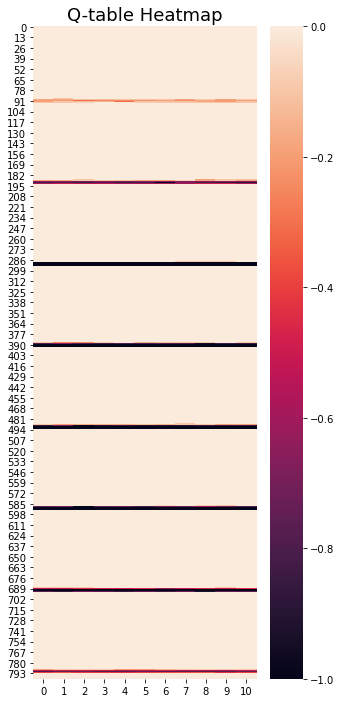

In [17]:
plt.figure(figsize=(5,12))
sns.heatmap(q_table[4600:5400], vmin=0, vmax=-1)
plt.title('Q-table Heatmap', fontsize=18)

In [23]:
df_q[9].unique()

array([ 0.        , -0.1       , -0.199     , -0.62725732, -0.85534299,
       -0.84673988, -0.4900995 , -0.71933374, -1.46841166, -1.52002688,
       -1.61533535, -1.60106868, -0.83832106, -1.63817211, -2.1932608 ,
       -2.239829  , -2.27779   , -0.19801   , -0.86482753, -1.57268417,
       -2.23966335, -2.83211296, -2.27900243, -0.72504025, -1.49794466,
       -2.26431518, -2.26431678, -1.69223802, -1.22451469, -1.70682666,
       -1.34342921, -0.73984271, -0.5631048 , -0.75916925, -0.43666335])

In [24]:

from matplotlib.patches import Circle, Rectangle, Arc
import matplotlib as mpl
#https://www.jphwang.com/nba-shot-data-analytics-visualization-with-python-pandas-and-matplotlib-part-2-grouping-data-by-area/
# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def create_court(ax, color):
    
    # Short corner 3PT lines
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)
    
    # 3PT Arc
    ax.add_artist(mpl.patches.Arc((0, 140), 440, 315, theta1=0, theta2=180, facecolor='none', edgecolor=color, lw=2))
    
    # Lane and Key
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((0, 190), 60, facecolor='none', edgecolor=color, lw=2))
    
    # Rim
    ax.add_artist(mpl.patches.Circle((0, 60), 15, facecolor='none', edgecolor=color, lw=2))
    
    # Backboard
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set axis limits
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)
    
    return ax

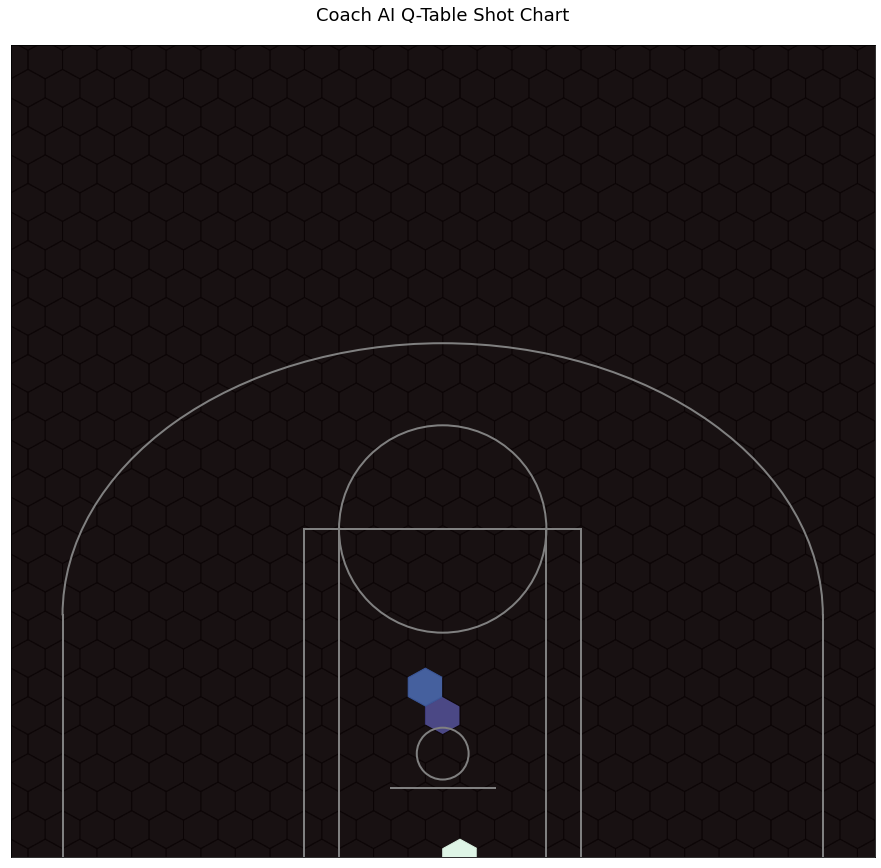

In [32]:
fig = plt.figure(figsize=(4*3, 3.76*3))
ax = fig.add_axes([0, 0, 1, 1])

# Draw court
ax = create_court(ax, 'grey')

# Plot hexbin of shots
ax.hexbin(df_q[9] // env._grid_shape[0], df_q[9] % env._grid_shape[1], gridsize=(30, 30), extent=(-300, 300, -50, 940), bins='log', cmap='mako', alpha=.95)

# Annotate player name and season
plt.title('Coach AI Q-Table Shot Chart\n', transform=ax.transAxes, ha='center', fontsize=18, pad=15)

# Save and show figure
plt.savefig('../images/AI_shot_chart.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pixel_per_grid = 5
im = Image.open('../images/Basketball_court-Model.jpg')
draw = ImageDraw.Draw(im)
# im = im.rotate(90)

In [ ]:
im.size

In [ ]:
for agent_i in [0,1]:
    drawCirc(draw, env.agent_pos[agent_i][0]*5, env.agent_pos[agent_i][1]*5, 'blue')
for agent_i in [2,3]:
    drawRect(draw, env.agent_pos[agent_i][0]*5, env.agent_pos[agent_i][1]*5, 'orange')

In [ ]:
env._grid_shape[1]*5

In [ ]:
image = Image.new("RGB", (500, 470), 'white')
drawText = ImageDraw.Draw(image)
fnt = ImageFont.truetype("C:/Windows/Fonts/arial.ttf ", 36)
def drawText(img, txt, x, y, color):
    img.text([x*image.size[0], y*image.size[1]], txt, fnt=fnt, fill=color)

if q_table is not None:
        arrows = ['N/A', '^','^>','>','v>','v','<v','<','^<', 'O', 'P']
        num_states = env._grid_shape[0] * env._grid_shape[1]
        for s in range(num_states):
            (x,y) = env.get_pos_from_state_num(s)
            action_index = np.argmax(q_table[s])
            arrow = arrows[action_index]
            drawText(draw, arrow, x, y, 'blue')

In [ ]:
image.show()

In [ ]:
# visualization parameters
gridsize = 5    # pixels per grid square
border = 1         # in pixels

def drawRect(img, x, y, color):
    img.rectangle([x*gridsize+4*border, y*gridsize+4*border, (x+1)*gridsize-2*border, (y+1)*gridsize-2*border], fill=color)

def drawCirc(img, x, y, color):
    img.rectangle([x*gridsize+4*border, y*gridsize+4*border, (x+1)*gridsize-2*border, (y+1)*gridsize-2*border], fill=color)    
    
def drawText(img, txt, x, y, color):
    img.text([x*gridsize+4*border, y*gridsize+4*border], txt, fnt=fnt, fill=color)

def drawEnvironment(env, q_table=None):
    imageSize = env._grid_shape[0]*env._grid_shape[1]*gridsize + border*2
    image = Image.new("RGB", (imageSize, imageSize), 'white')
    imageDraw = ImageDraw.Draw(image)
    # draw the grid
    for row in range(env._grid_shape[0]+1):
        imageDraw.line([border, row*gridsize+border, imageSize-border, row*gridsize+border], 'black', border)
    for col in range(env._grid_shape[1]+1):
        imageDraw.line([col*gridsize+border, border, col*gridsize+border, imageSize-border], 'black', border)

    # agent is blue, goal is red, and walls are black
    for agent_i in [0,1]:
        drawCirc(imageDraw, env.agent_pos[agent_i][0], env.agent_pos[agent_i][1], 'blue')
    for agent_i in [2,3]:
        drawRect(imageDraw, env.agent_pos[agent_i][0], env.agent_pos[agent_i][1], 'blue')

    drawItem(imageDraw, env.GOAL[0], env.GOAL[1], 'orange')

    if q_table is not None:
        arrows = ['^','^>','>','v>','v','<v','<','^<', 'O', 'P']
        num_states = env.num_states()
        for s in range(num_states):
            (x,y) = env.get_pos_from_state_num(s)
            action_index = np.argmax(q_table[s])
            arrow = arrows[action_index]
            drawText(imageDraw, arrow, x, y, 'green')

    display(image)

#### Analysis of Q-Learning

The agents definitely learned that some actions led to worse rewards from the heatmap. 